In [1]:
%matplotlib notebook
from astropy.io import fits
from astropy.visualization import simple_norm
from gammapy.maps import Map
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import healpy as hp
import numpy as np

``python makeFitsImage.py -i output/annihil_rs01_gamma052D_FOVdiameter2.0deg_nside1024.fits -e 3 -c 3``

In [2]:
outfile = './datasets/annihil_Perseus_A4262D_FOVdiameter2.0deg_nside1024-INTEGRATED_FLUXES-Flux_gamma-image.fits'
# outfile = './datasets/annihil_Perseus_A4262D_FOVdiameter2.0deg_nside1024-INTEGRATED_FLUXES-Intensity_gamma-image.fits'
#hdulist = fits.open(outfile)
#hdulist.info()

In [3]:
#hdu = hdulist[0]
#hdu.header

In [4]:
map_dm = Map.read(outfile)

keyword looks very much like CDELTia but isn't. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


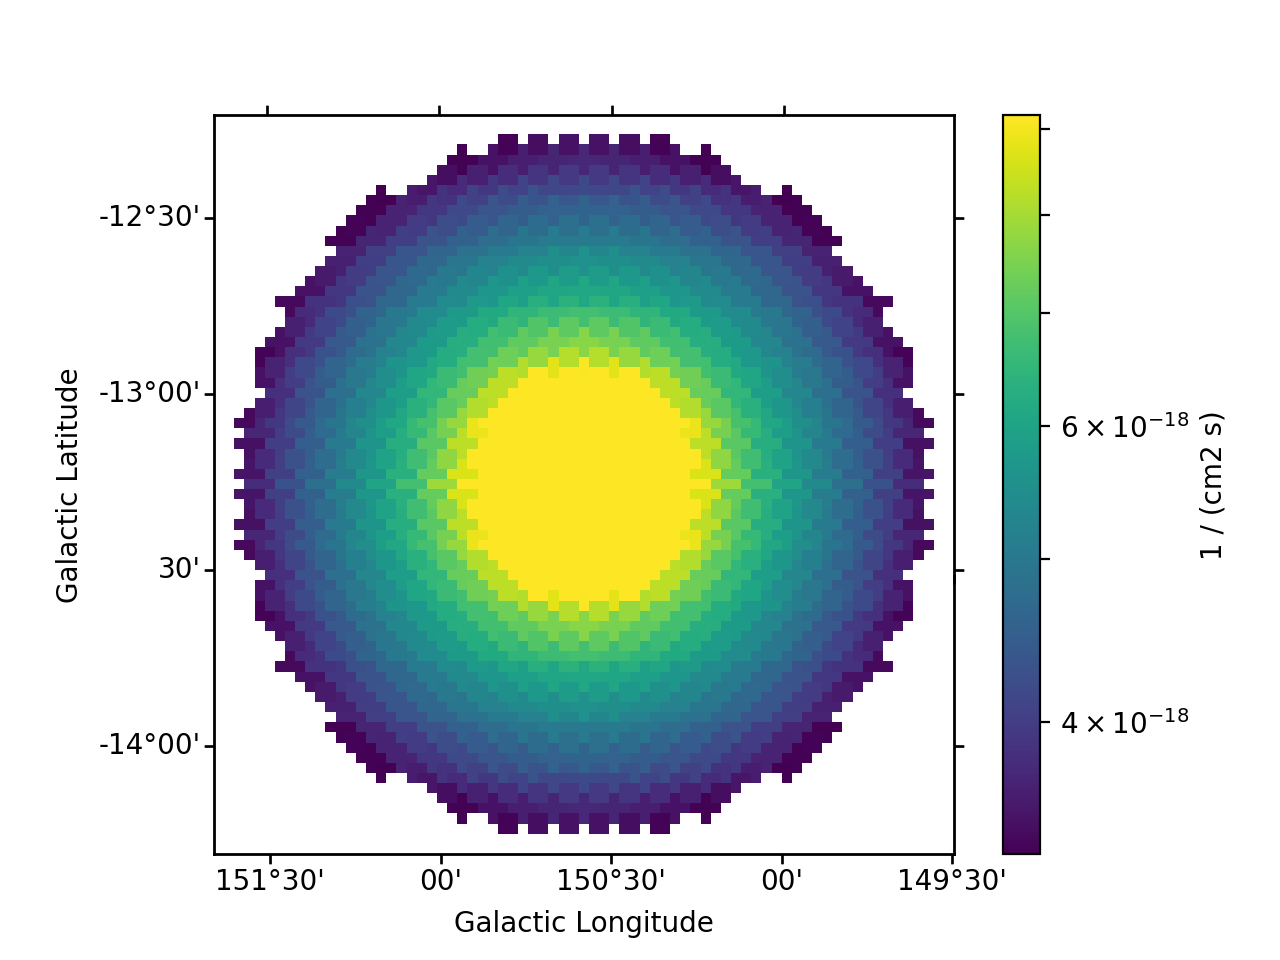

In [5]:
map_dm.plot(cmap="viridis", vmax=map_dm.data[map_dm.data>0].max()/50, norm=LogNorm(), add_cbar=True);